# Inria Dataset Analysis 

**Objectif:** le but de ce notebook est d'explorer et de visualiser les données du dataset Inria pour mieux comprendre quelles sont les données avec lesquelles on travaille. 

### Root Variables 

In [1]:
import os 

In [2]:
root = '/home/ign.fr/ttea/Code_IGN/AerialImageDataset'
train_dir = os.path.join(root,'train/images')
gt_dir = os.path.join(root,'train/gt')
test_dir = os.path.join(root,'test/images')

### Import Libraries 

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils import data

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
from rasterio.windows import Window

## Inria Dataset

L'Étiquetage des images aériennes Inria aborde un thème central de la télédétection : l'étiquetage automatique au pixel près de l'imagerie aérienne
    
    
**Caractéristiques de l'ensemble de données :**

- Couverture de 810 km² (405 km² pour l'entraînement et 405 km² pour les tests)
    
- Imagerie aérienne couleur orthorectifiée avec une résolution spatiale de 0,3 m
    
- Données de vérité terrain pour deux classes sémantiques : construction et non construction (divulguées publiquement uniquement pour le sous-ensemble d'apprentissage)

On affiche le nombre d'images dans les dossier d'entraînement, test et vérité terrain.

In [4]:
print("Nombre d'images pour l'entraînement :",len(os.listdir(train_dir)))
print("Nombre d'images pour le test:",len(os.listdir(test_dir)))
print("Nombre d'images vérité terrain:",len(os.listdir(gt_dir)))

Nombre d'images pour l'entraînement : 180
Nombre d'images pour le test: 180
Nombre d'images vérité terrain: 180


On utilise la librairie rasterio pour la lecture d'image, la fonction read_image prend en entrée : 
- root: la racine du dossier
- filename : le nom du fichier 

Cela va nous retourner l'image sous forme de numpy array.

Les images du jeu de données Inria sont de taille 5000x5000 (largeur, hauteur). Elles prennent beaucoup de place dans la mémoire, on va donc les tuiler avec la fonction **get_tile** qui prend en entrée: 
- root : la racine 
- image_file : le nom de l'image
- tile_size : la largeur et la hauteur que l'on souhaite tuiler 
- idx: indice (partie de l'image que l'on veut tuiler)

Cela va nous retourner la tuile choisit.

### Lecture et visualisation de l'image 

In [5]:
def read_image(root,filename):
    """
    root : root directory 
    filename : image filename as string
    
    Returns: raster as an array 
    """
    img = rasterio.open(os.path.join(root,filename))
    img_array = img.read()
    img.close()
    return img_array

On affiche une image du jeu de donnée Inria. 

image filename: tyrol-w11.tif


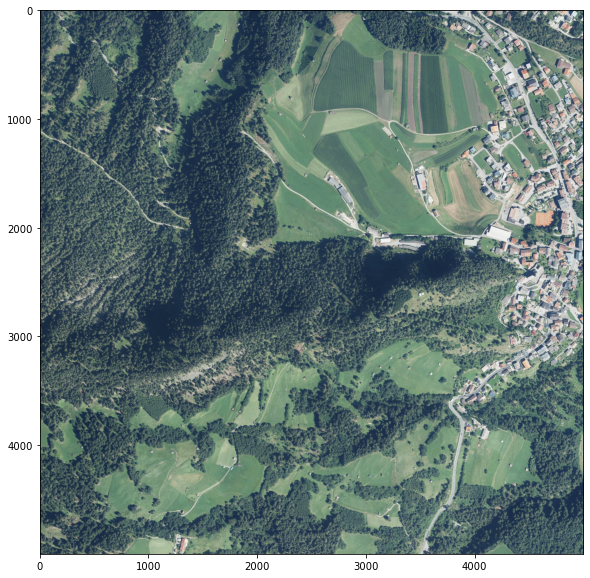

In [6]:
list_train = os.listdir(train_dir)
first_img =  list_train[0]
print('image filename:',first_img)
img = rasterio.open(os.path.join(train_dir,first_img))
raster_img = reshape_as_image(img.read())

plt.figure(figsize=(10,10))
plt.imshow(raster_img)

### Fonction de tuilage 

In [7]:
def get_tile(root,image_file,tile_size,idx):
    """
    image_file : image filename as string
    tile_size : tuple of the dimension for the tile (width, height)
    idx : index of the tile, int
    
    Returns: tile of the image file [channel,width,height] -> [nb tile , channel, width, height]
    """

    # Read Image 
    image =rasterio.open(os.path.join(root,image_file))
    
    image_shape = np.shape(image)
    width = image_shape[0] 
    height= image_shape[1]
    
    tile_width = tile_size[0]
    tile_height = tile_size[1]
    
    # Number of tile 
    nb_tile_w = width // tile_width
    nb_tile_h = height // tile_height
    
    row,col = divmod(idx,nb_tile_w)
    
    tile = image.read(window=Window(col*tile_height,row*tile_width,tile_size[0],tile_size[1]))
    return tile    

### Tuile

On va tuiler une partie de l'image tyrol-w11 avec une tuile de taille 512x512.

In [8]:
tile_size = (512, 512)
tile_img = get_tile(train_dir,first_img,tile_size,3)
print(first_img)
print('shape tile',np.shape(tile_img))

tyrol-w11.tif
shape tile (3, 512, 512)


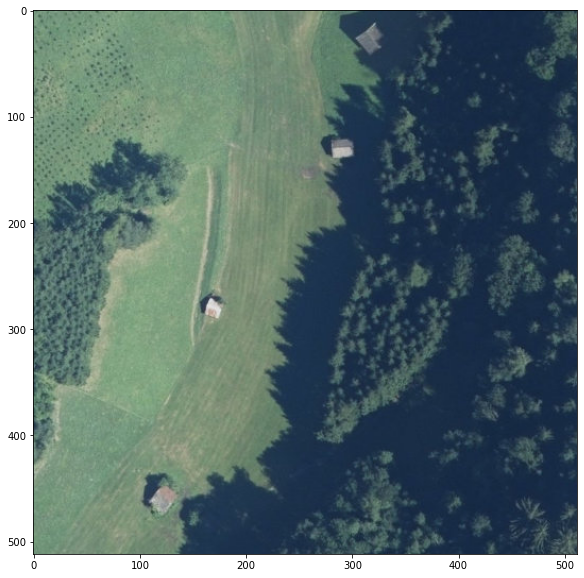

In [9]:
raster_tile = reshape_as_image(tile_img)

plt.figure(figsize=(10,10))
plt.imshow(raster_tile)

### Vérité Terrain 

On fait de même pour la vérité terrain de l'image. 

In [10]:
list_mask = os.listdir(gt_dir)
first_mask =  list_mask[0]
mask =  rasterio.open(os.path.join(gt_dir,first_mask))
print(first_mask)
print('shape mask:',np.shape(mask.read()))

tyrol-w11.tif
shape mask: (1, 5000, 5000)


In [11]:
tile_mask = get_tile(gt_dir,first_mask,tile_size,3)

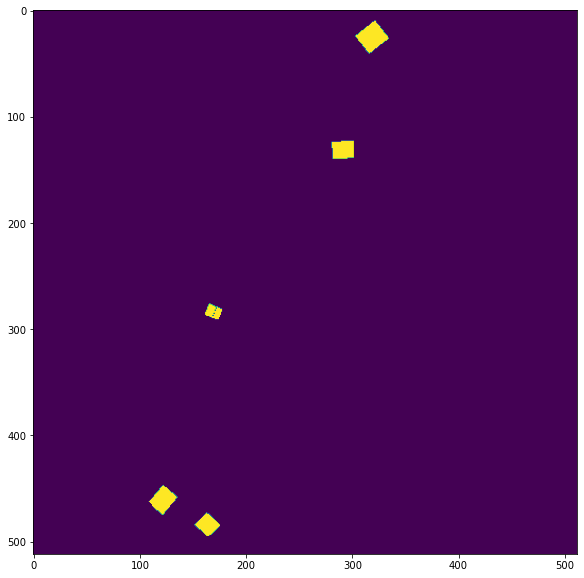

In [12]:
mask_tile = reshape_as_image(tile_mask)

plt.figure(figsize=(10,10))
plt.imshow(mask_tile)

### Images avec Bâtiments ou Non-Bâti 

On cherche ensuite à savoir si chaque image dans notre jeu de données contient des bâtiments ou non. On va donc calculer le pourcentage d'image qui contient des bâtiments. 

Pour savoir si l'image contient un bâtiment, on regarde la vérité terrain de l'image qui affichera seulement des 0 ou des 1 :
- 0 si le pixel ne contient pas de bâtiment.
- 1 si le pixel contient un bâtiment.

In [13]:
list_mask = os.listdir(gt_dir)
mask = read_image(gt_dir,list_mask[0])
print(mask)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


On fait la somme des toutes les valeurs de la vérité terrain, si tous les pixels ne contiennent pas de bâtiments, le masque sera égale à 0.

In [14]:
(mask==255).sum()

791117

In [15]:
label = []
for msk in list_mask:
    mask = read_image(gt_dir,msk)
    count = (mask==255).sum()
    if count >0 :
        label.append('Batiment')
    else:
        label.append('None')

On voit que toutes les images contiennent des bâtiments. 

In [16]:
label

['Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',
 'Batiment',

## Dataset

La class **Dataset** prend en entrée : 
- root : la racine qui mène vers le dossier ou est stockée le dataset
- tile size : la taille que l'on souhaite pour tuiler  
- mode : entraînement / validation / test
- transform : Transformation pour la data augmentation 
- filtered : Si l'on choisit des images contenant exclusivement que des Bâtiments ou non 
- part : Après avoir split le dataset en 5 (4 train / 1 validation), choisir une partie

In [17]:
class InriaDataset(Dataset):

    def __init__(self, root, tile_size, mode,part):
        self.root = root
        self.tile_size= tile_size
        self.mode = mode
        self.part = part
        
        # Initialisation des listes d'images 
        self.train_dir = os.path.join(root,'train/images')
        self.gt_dir = os.path.join(root,'train/gt')
        self.test_dir = os.path.join(root,'test/images')

        self.train_images = os.listdir(self.train_dir)
        self.test_images = os.listdir(self.test_dir)
        self.gt_images = os.listdir(self.gt_dir)
        
        # Datalist -> contient toutes les tuiles, only_bat -> contient seulement les tuiles ayant des bâtiments  
        self.datalist = []
        self.only_bat = []
        self.used_tiles = []
        self.tiles = []
        
        score = 0
        label= 'None'
        
        
        # Nombre de tuiles par images 
        # Toutes les images dans le jeu de données Inria ont les mêmes tailles, nous allons utiliser la première 
        # image comme référence 
        with rasterio.open(os.path.join(self.train_dir, self.train_images[0])) as first_img :
            # shape dimension is [C, W, H ]
            images_width = first_img.width
            images_heigth = first_img.height
        
        
        # On détermine la largeur & hauteur de la tuile 
        tile_width = self.tile_size[0]
        tile_heigth = self.tile_size[1]
        
        # Nombre de tuiles par colonnes & lignes, ainsi que le nobmre de tuile par image 
        nb_tile_col = images_width // tile_width
        nb_tile_row = images_heigth // tile_heigth
        self.nb_tile_by_image = nb_tile_col*nb_tile_row
            
        for id_image in range(0, len(self.train_images)):
            train_image = self.train_images[id_image]
            gt_image = self.gt_images[id_image]
            for id_tile in range(0, self.nb_tile_by_image):
                self.datalist.append((id_tile, train_image, gt_image))

        self.used_tiles = self.datalist


        # Split le dataset en 80/20 (Train/Valid)
        slice_20= int(len(self.used_tiles)*(0.2))
        
        # On divise le dataset en 5 partie (4 pour l'entraînement, 1 pour la validation)
        
        # 1/5 -> validation is 1/5
        if self.part == 1 :
            if self.mode == 'train':
                del self.used_tiles[:slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[:slice_20]
       
        # 2/5
        if self.part == 2:
            if self.mode == 'train':
                del self.used_tiles[slice_20:2*slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[slice_20:2*slice_20]
        
        # 3/5
        if self.part == 3:
            if self.mode == 'train':
                del self.used_tiles[2*slice_20:3*slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[2*slice_20:3*slice_20]
        # 4/5
        if self.part == 4:
            if self.mode == 'train':
                del self.used_tiles[3*slice_20:4*slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[3*slice_20:4*slice_20]
        # 5/5
        if self.part == 5:
            if self.mode == 'train':
                del self.used_tiles[4*slice_20:]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[4*slice_20:]
            
        # test mode 
        else: 
            self.images = self.test_images
            
    def __len__(self):
        
        return len(self.tiles)

    def __getitem__(self, idx):
        
        if self.mode =='test':
            root = self.test_dir
        else:
            root = self.train_dir
        
        tile_data = self.tiles[idx]
        id_image, id_tile = tile_data[1], tile_data[0]
                    
        image = self._get_tile(self.train_dir, id_image, id_tile)
        mask = self._get_tile(self.gt_dir, id_image, id_tile)   
        mask[np.where(mask==255)] = 1
        
        image_tensor = torch.from_numpy(image).float()
        mask_tensor = torch.from_numpy(mask)
        
        return image_tensor, mask_tensor[0,:,:]
    
    
    def _get_tile(self, root, image_file, idx):
        
        with rasterio.open(os.path.join(root, image_file)) as dataset :

            width = dataset.width
            height= dataset.height

            tile_width = self.tile_size[0]
            tile_height = self.tile_size[1]

            nb_tile_w = width // tile_width
            nb_tile_h = height // tile_height

            row, col = divmod(idx, nb_tile_w)

            tile = dataset.read(window=Window(col*tile_height,row*tile_width,tile_size[0],tile_size[1]))
            return tile  

In [18]:
# InriaDataloader : root,batch_size,tile_loader, tile_size ,mode,transform, filtered , part
tile_size = (256,256)
train_dataset = InriaDataset(root, tile_size, 'train',1)
val_dataset =  InriaDataset(root, tile_size, 'validation',1)

train_dataloader = DataLoader(train_dataset, 8, num_workers=6,  drop_last=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, 8, num_workers=6, drop_last=True)

### Visualisation Dataset - Dataloader 

Une fois que nous avons défini notre dataset, la fonction view va nous permettre de visualiser des tuiles spécifiques et leurs masques associés du dataset. Elle prendra en entrée :
- Dataset
- idx : l'indice de la tuile que l'on souhaite visualiser 

In [19]:
def view(dataset, idx):
    """
    dataset: dataset contains tile & mask 
    idx : index 
    
    Returns : plot tile & mask  
    """
    
    item = dataset[idx]
    
    raster_tile = reshape_as_image(np.array(item[0]).astype(np.uint8))
    raster_gt = reshape_as_image(np.array(item[1][None,:,:]))
    
    figure, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,6))
    
    ax[0].imshow(raster_tile)
    ax[0].set_title('Raster Tile')
    ax[0].set_axis_off()
    
    ax[1].imshow(raster_gt)
    ax[1].set_title('Raster Gt')
    ax[1].set_axis_off()
    
    plt.tight_layout()
    plt.show()

On affiche une tuile spécifique et le masque associé du dataset. 

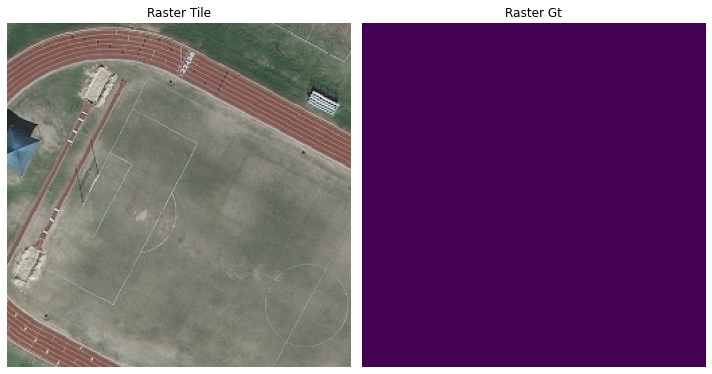

In [20]:
view(train_dataset, 5042)

La fonction view batch permet de visualiser les tuiles et les masques associés par batch. 

In [21]:
def view_batch(tiles, gt , pred = None, size = None, ncols = None):
    
    batch_size = tiles.shape[0]
    ncols = batch_size
    if size is not None :
        ncols = size
        
    if pred is None :
        figure, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(20, 8))    
    else : 
        figure, ax = plt.subplots(nrows=3, ncols=ncols, figsize=(20, 12))    
        # ax[0][idx].set_t
        
    for idx in range(ncols):
        
        item_tile = tiles[idx]
        item_gt = gt[idx]

        raster_tile = reshape_as_image(np.array(item_tile).astype(np.uint8))
        raster_gt = reshape_as_image(np.array(item_gt[None,:,:]))

        ax[0][idx].imshow(raster_tile)
        # ax[0][idx].set_title('Raster Tile '+str(idx))
        ax[0][idx].set_axis_off()

        ax[1][idx].imshow(raster_gt)
        # ax[1][idx].set_title('Raster Gt '+str(idx))
        ax[1][idx].set_axis_off()
        
        if pred is not None :
            item_pred = pred[idx]
            raster_pred = reshape_as_image(np.array(item_pred[None,:,:]))
            ax[2][idx].imshow(raster_pred)
            # ax[1][idx].set_title('Raster Gt '+str(idx))
            ax[2][idx].set_axis_off()

    plt.tight_layout()
    plt.show()

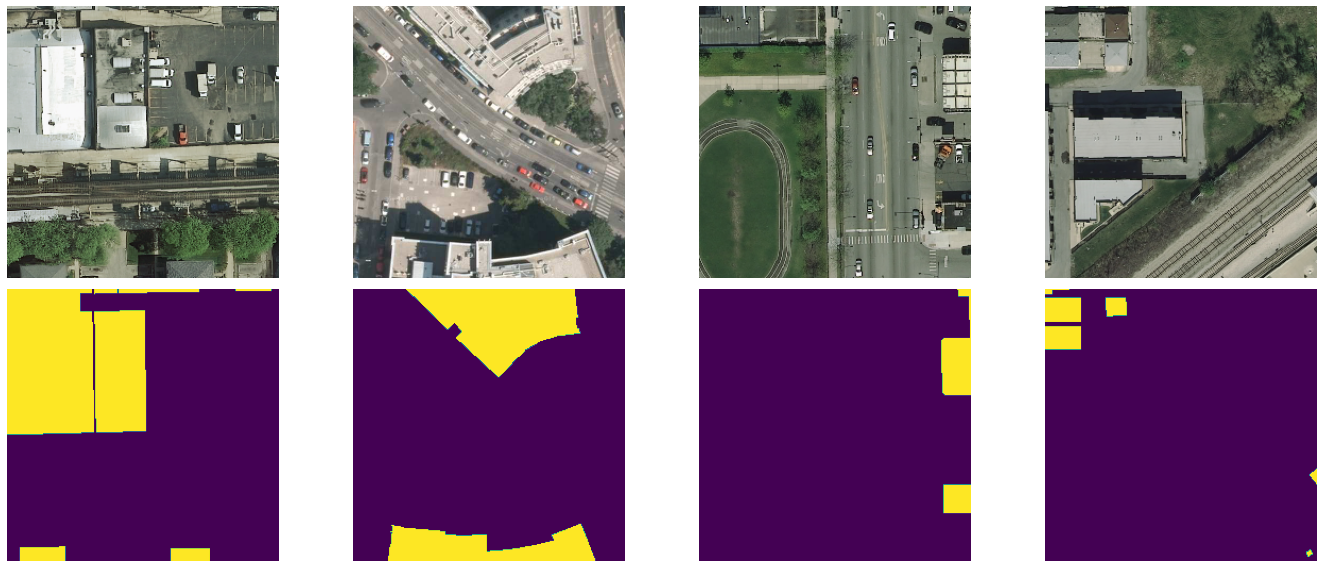

In [22]:
tiles_1, gt_1 = next(iter(train_dataloader))
view_batch(tiles_1, gt_1 , size = 4)